# Setup

In [1]:
# Common imports
import sys
import os
import random
import sklearn
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import PIL

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_random_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib.pyplot as plt

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Directories
localDir = 'images/lego/'

# Images
imgWidth = 64
imgHeight = 64

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# Make images into multidimensional arrays

In [2]:
def convertImageToArray(fileName):
    an_image = PIL.Image.open(fileName).convert('L')
    image_sequence = an_image.getdata()
    return np.array(image_sequence).reshape(imgWidth, imgHeight)

In [3]:
IndexToBrickId = {}
brickIdImageKeyPairs = []

for index, key in enumerate(os.listdir(localDir)):
    print(key)
    IndexToBrickId[index] = key
    
    fileList = os.listdir(localDir + key)
    listLenStr = str(len(fileList))
    for index2, fileName in enumerate(fileList):
        filePath = localDir + key + '/' + fileName
        print(str(index2+1).zfill(len(listLenStr)) + '/' + listLenStr + ' - ' + filePath + (' ' * 256), end='\r')
        brickIdImageKeyPairs.append((index, convertImageToArray(filePath)))
    print(listLenStr + '/' + listLenStr + ' - Finished converting' + (' ' * 256))
print('\nFinished converting all')

3001


1621/1621 - Finished converting                                                                                                                                                                                                                                                                
3003


1322/1322 - Finished converting                                                                                                                                                                                                                                                                
3004


1627/1627 - Finished converting                                                                                                                                                                                                                                                                

Finished converting all


# Randomize order

In [4]:
brickIdIndexes = []
images = []

random.shuffle(brickIdImageKeyPairs)
for item in brickIdImageKeyPairs:
    brickIdIndexes.append(item[0])
    images.append(item[1])

In [5]:
print(brickIdIndexes[0])
print(IndexToBrickId[0])
print(images[0] / 255)
print(len(images[0]))

1
3001
[[0.47058824 0.48235294 0.49411765 ... 0.51764706 0.51372549 0.50980392]
 [0.47058824 0.48235294 0.49411765 ... 0.51764706 0.51372549 0.50980392]
 [0.4745098  0.48235294 0.49019608 ... 0.51764706 0.51372549 0.50980392]
 ...
 [0.46666667 0.46666667 0.46666667 ... 0.5254902  0.5254902  0.52156863]
 [0.46666667 0.46666667 0.46666667 ... 0.52941176 0.52941176 0.5254902 ]
 [0.46666667 0.46666667 0.46666667 ... 0.52941176 0.52941176 0.5254902 ]]
64


# Machine Learning
Decision forest

In [6]:
percentageToTakeTrainFull = int(len(brickIdIndexes) * 0.9)
print('Train ' + str(percentageToTakeTrainFull) + '/' + str(len(brickIdIndexes)))
X_train_full = np.asarray(images[:percentageToTakeTrainFull])
y_train_full = np.asarray(brickIdIndexes[:percentageToTakeTrainFull])
X_test = np.asarray(images[percentageToTakeTrainFull:])
y_test = np.asarray(brickIdIndexes[percentageToTakeTrainFull:])

Train 4113/4570


In [7]:
# Show the size and dimension of the dataset.
X_train_full.shape

(4113, 64, 64)

In [8]:
# Each pixel intensity is represented as a byte (0 to 255).
X_train_full.dtype

dtype('int64')

In [9]:
percentageToTakeForValidation = len(X_test)
print('Validate ' + str(percentageToTakeForValidation) + '/' + str(len(X_train_full)))

# Split the full training set into a validation set and a (smaller) training set,
# and scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.
X_valid, X_train = X_train_full[:percentageToTakeForValidation] / 255., X_train_full[percentageToTakeForValidation:] / 255.
y_valid, y_train = y_train_full[:percentageToTakeForValidation], y_train_full[percentageToTakeForValidation:]
X_test = X_test / 255.

Validate 457/4113


In [10]:
X_train.shape

(3656, 64, 64)

In [11]:
X_valid.shape

(457, 64, 64)

In [12]:
X_test.shape

(457, 64, 64)

# Show random image and class

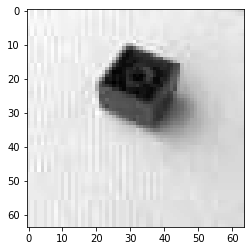

In [13]:
#Plot an image using Matplotlib's imshow() function, with a gray color map:
plt.imshow(X_train[0], cmap='gray')
plt.show()

In [14]:
# Show the name of the first image in the training set.
IndexToBrickId[y_train[0]]

'3003'

## Standardize the data
Because we want to use the SELU activation function and LeCun weight initializer, we should standardize all the input features to a mean of 0 and a standard deviation of 1. Since each pixel is an input feature, there are 28x28=784 input features, and we need to compute the mean and standard deviation for each of them.

In [15]:
# Compute the mean for each pixel.
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_means.shape

(1, 64, 64)

In [16]:
# Compute the standard deviation for each pixel.
pixel_stds = X_train.std(axis=0, keepdims=True)
pixel_stds.shape

(1, 64, 64)

In [17]:
# Scale the inputs to mean 0 and standard deviation 1 to achieve self-normalization with SELU and LeCun.
X_train_standardized = (X_train - pixel_means) / pixel_stds
X_valid_standardized = (X_valid - pixel_means) / pixel_stds
X_test_standardized = (X_test - pixel_means) / pixel_stds

In [18]:
# Validate that the mean is close to 0 for each pixel.
X_train_standardized.mean(axis=0, keepdims=True)

array([[[-9.29223420e-14, -7.17016709e-14, -2.87544575e-14, ...,
          2.07072749e-13,  1.83122664e-13,  1.75809100e-13],
        [-5.13414871e-14, -2.63505075e-14,  2.20517517e-14, ...,
          2.27907591e-13,  2.02706105e-13,  1.81785628e-13],
        [ 2.50431969e-14,  3.42161717e-14,  5.10947199e-14, ...,
          2.31058213e-13,  2.23978901e-13,  2.17156010e-13],
        ...,
        [-2.33454819e-13, -2.26311797e-13, -2.27515156e-13, ...,
          2.27671942e-14,  3.08424572e-14,  2.95489988e-14],
        [-2.27393444e-13, -2.28825438e-13, -2.26847990e-13, ...,
          1.36299008e-14,  1.87470389e-14,  1.98370678e-14],
        [-2.28915871e-13, -2.31379437e-13, -2.30306292e-13, ...,
          2.59490338e-15,  1.16093009e-14,  7.86463649e-15]]])

In [19]:
# Validate that the standard deviation is close to 1 for each pixel.
X_train_standardized.std(axis=0, keepdims=True)

array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]])

# Randomized Search Report

In [20]:
def build_classifier(layerCount=1, 
                     neuronCount=100, 
                     activationFunction='relu', 
                     kernelInitializer='glorot_uniform',
                     outputNeuronCount=10,
                     optimizer='sgd', 
                     learningRate=0.005, 
                     momentum = 0.0):
    model = keras.models.Sequential()
    
    model.add(keras.layers.Flatten(input_shape=[imgWidth, imgHeight]))

    kernelInitializerFound = 'lecun_normal' if activationFunction == 'selu' else kernelInitializer
    for layerIndex in range(layerCount):
        model.add(keras.layers.Dense(units=neuronCount, activation=activationFunction, kernel_initializer=kernelInitializerFound)),
    
    # Softmax is default for multiclass classification.
    model.add(keras.layers.Dense(units=outputNeuronCount, activation="softmax"))
    
    foundOptimizer = optimizer
    if optimizer == 'sgd':
        foundOptimizer=keras.optimizers.SGD(lr=learningRate, momentum=momentum)
    elif optimizer == 'adam':
        foundOptimizer=keras.optimizers.Adam(learning_rate=learningRate)
    
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=foundOptimizer,
                  metrics=["accuracy"])
            
    return model

In [24]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

# EarlyStopping (with rollback to the best model).
class_early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# Performance scheduling
# (multiply the learning rate by a factor when the error stops dropping for a number of epochs, called patience)
class_lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=4)

classifier = KerasClassifier(build_fn=build_classifier)
params=dict(layerCount=[1],#, 2, 3],
            neuronCount=[50],#, 100, 150],
            activationFunction=['relu'],#, 'selu'],
            kernelInitializer=['random_normal'],#, 'glorot_normal'],
            outputNeuronCount=[5],#, 10, 15],
            optimizer=['sgd'],#, 'adam'],
            learningRate=[0.01],#, 0.1, 1],
            momentum = [0.0, 0.5, 0.9])

gcv = GridSearchCV(classifier, param_grid=params)
gcv.fit(X_train_standardized, y_train,
         validation_data=(X_valid_standardized, y_valid),
         epochs=30, verbose=1,
         callbacks=[class_lr_scheduler, class_early_stopping])

Train on 2924 samples, validate on 457 samples
Epoch 1/30
2924/2924 [==============================] - 6s 2ms/sample - loss: 0.3548 - acc: 0.9330 - val_loss: 0.0895 - val_acc: 0.9934
Epoch 2/30
2924/2924 [==============================] - 1s 268us/sample - loss: 0.0721 - acc: 0.9918 - val_loss: 0.0318 - val_acc: 0.9978
Epoch 3/30
2924/2924 [==============================] - 1s 248us/sample - loss: 0.0298 - acc: 0.9956 - val_loss: 0.0203 - val_acc: 0.9978
Epoch 4/30
2496/2924 [========================>.....] - ETA: 0s - loss: 0.0176 - acc: 0.9972

KeyboardInterrupt: 

In [23]:
pd.concat([pd.DataFrame(gcv.cv_results_["params"]),
           pd.DataFrame(gcv.cv_results_["mean_test_score"], columns=["Accuracy"])], axis=1
         ).sort_values(by='Accuracy', ascending=False)

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

# Create a model using the Sequential API

In [ ]:
model = keras.models.Sequential([
# Input layer:
# A "Flatten" layer converts each input image into a 1-dimensional array.
keras.layers.Flatten(input_shape=[imgWidth, imgHeight]),

# Hidden layers:
# A dense layer is fully connected.
keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),

# Output layer.
# The layer contains one neuron per class (i.e. 10).
# Since it is multiclass classification, we should use the softmax activation function.
# It will ensure that the estimated probabilities are between 0 and 1, and that the sum
# of estimated probabilities for one prediction is 1.
# (for binary classification we would have a single output neuron using the logistic activation function).
keras.layers.Dense(10, activation="softmax")])

### Show information about the model

In [ ]:
model.summary()

In [ ]:
hidden1 = model.layers[1]
hidden1.name

In [ ]:
weights, biases = hidden1.get_weights()

In [ ]:
weights

In [ ]:
weights.shape

In [ ]:
biases

In [ ]:
biases.shape

## Compile the model
You must at least specify the loss function and the optimizer to use. You can also specify a list of additional metrics to use during training and evaluation.

In [ ]:
# "sparse_categorical_crossentropy" is the loss function to use for classification when the classes are exclusive.
# "sgd" means Stochastic Gradient Descent.
# "accuracy" enables us to measure the accuracy during training and evaluation.
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(momentum=0.9),
              metrics=["accuracy"])

## Train the model

In [ ]:
# EarlyStopping (with rollback to the best model).
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# Performance scheduling
# (multiply the learning rate by a factor when the error stops dropping for a number of epochs, called patience)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=4)

# Train the model with early stopping or performance scheduling or both. Training is much faster when
# early stopping is used, but a slightly better accuracy is achieved with performance scheduling alone.
history = model.fit(X_train_standardized, y_train, epochs=30,
                    validation_data=(X_valid_standardized, y_valid),
                    callbacks=[lr_scheduler, early_stopping])

In [ ]:
# The fit() method returns a history object with information about the result of the training.
history.params

In [ ]:
print(history.epoch)

In [ ]:
history.history.keys()

In [ ]:
# Show the learning curves.
# (The training curves should be shifted half an epoch to the left to be completely comparable with
# the validation curves).

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Evaluate the model.

In [ ]:
model.evaluate(X_test_standardized, y_test)

In [ ]:
# Make predictions with probabilities for the first 3 instances in the test set.
X_new = X_test_standardized[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

In [ ]:
# Make predictions without probabilities.
y_pred = model.predict_classes(X_new)
y_pred

In [ ]:
# Check if the predictions were coorrect.
y_new = y_test[:3]
y_new

In [ ]:
# Compare image and classes.
newClassList = np.array(list(IndexToBrickId.values()))[y_pred]

for i in range(3):
    plt.imshow(X_new[i], cmap='gray')
    plt.show()
    print(newClassList[i])